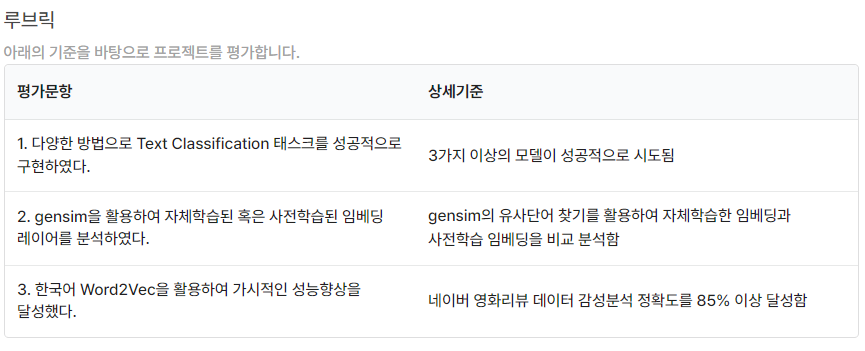

# 8-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기


이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해 주세요

### 라이브러리 버전을 확인해 봅니다
----
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
4.2.0


In [42]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### 1) 데이터 준비와 확인
----

In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성
----
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴


mecab 설치
- https://doitgrow.com/39

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

mecabpath = 'C:\\mecab\\mecab-ko-dic\\'
tokenizer = Mecab(mecabpath)
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown

In [6]:
word_to_index

{'': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시간': 95,
 '지루': 96,
 '중': 97,
 '재미있': 98,
 '년': 

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델 구성을 위한 데이터 분석 및 가공
----
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

- 식에 따라 정해진 최대값은 41단어였는데, 조금더 포함시키기 위해 10단어길이를 추가했다. 
- 결과적으로 해당하는 문장의 비율이 93% -> 96%로 늘어났다. 

In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens) + 10
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  51
전체 문장의 0.9631000465856793%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

In [12]:
print(X_train.shape)
print(X_test.shape)

(146182, 51)
(49157, 51)


In [36]:
print(y_train.shape)
print(y_test.shape)

(146182,)
(49157,)


In [18]:
print(index_to_word[0])
print(index_to_word[1])
print(index_to_word[2])

<PAD>
<BOS>
<UNK>


In [19]:
X_train[0]

array([ 32,  74, 919,   4,   4,  39, 228,  20,  33, 748,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [38]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 51)
(136182,)


### 4) 모델 구성 및 validation set 구성
----
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

In [62]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 40  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_lstm1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model_lstm1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 40)          400000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 20)                4880      
_________________________________________________________________
dense_30 (Dense)             (None, 16)                336       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 405,233
Trainable params: 405,233
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_conv1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.Conv1D(16, 7, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Conv1D(16, 7, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_conv01.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 40)          400000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          4496      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [34]:
model_gmp1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gmp01.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 40)          400000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 40)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 328       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 400,337
Trainable params: 400,337
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시
----

In [65]:
model_lstm1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm1 = model_lstm1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 17s 50ms/step - loss: 0.5160 - accuracy: 0.7075 - val_loss: 0.3542 - val_accuracy: 0.8460
Epoch 2/10
266/266 [==============================] - 12s 45ms/step - loss: 0.3357 - accuracy: 0.8566 - val_loss: 0.3411 - val_accuracy: 0.8464
Epoch 3/10
266/266 [==============================] - 12s 44ms/step - loss: 0.3115 - accuracy: 0.8662 - val_loss: 0.3380 - val_accuracy: 0.8526
Epoch 4/10
266/266 [==============================] - 12s 45ms/step - loss: 0.2942 - accuracy: 0.8727 - val_loss: 0.3477 - val_accuracy: 0.8494
Epoch 5/10
266/266 [==============================] - 12s 45ms/step - loss: 0.2793 - accuracy: 0.8779 - val_loss: 0.3495 - val_accuracy: 0.8504
Epoch 6/10
266/266 [==============================] - 12s 46ms/step - loss: 0.2636 - accuracy: 0.8843 - val_loss: 0.3690 - val_accuracy: 0.8516
Epoch 7/10
266/266 [==============================] - 12s 44ms/step - loss: 0.2533 - accuracy: 0.8878 - val_loss: 0.3661 - val_accuracy:

In [68]:
model_conv1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_conv1 = model_conv1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 22s 37ms/step - loss: 0.4712 - accuracy: 0.7643 - val_loss: 0.3444 - val_accuracy: 0.8478
Epoch 2/10
266/266 [==============================] - 9s 34ms/step - loss: 0.3153 - accuracy: 0.8668 - val_loss: 0.3300 - val_accuracy: 0.8535
Epoch 3/10
266/266 [==============================] - 9s 35ms/step - loss: 0.2794 - accuracy: 0.8848 - val_loss: 0.3285 - val_accuracy: 0.8570
Epoch 4/10
266/266 [==============================] - 10s 37ms/step - loss: 0.2480 - accuracy: 0.9008 - val_loss: 0.3394 - val_accuracy: 0.8544
Epoch 5/10
266/266 [==============================] - 10s 37ms/step - loss: 0.2123 - accuracy: 0.9189 - val_loss: 0.3580 - val_accuracy: 0.8538
Epoch 6/10
266/266 [==============================] - 10s 36ms/step - loss: 0.1737 - accuracy: 0.9365 - val_loss: 0.3893 - val_accuracy: 0.8513
Epoch 7/10
266/266 [==============================] - 10s 36ms/step - loss: 0.1367 - accuracy: 0.9525 - val_loss: 0.4373 - val_accuracy: 0

In [69]:
model_gmp1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp1 = model_gmp1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 9s 31ms/step - loss: 0.5291 - accuracy: 0.7522 - val_loss: 0.3697 - val_accuracy: 0.8398
Epoch 2/10
266/266 [==============================] - 8s 30ms/step - loss: 0.3371 - accuracy: 0.8575 - val_loss: 0.3352 - val_accuracy: 0.8519
Epoch 3/10
266/266 [==============================] - 8s 31ms/step - loss: 0.2937 - accuracy: 0.8790 - val_loss: 0.3340 - val_accuracy: 0.8536
Epoch 4/10
266/266 [==============================] - 8s 30ms/step - loss: 0.2649 - accuracy: 0.8932 - val_loss: 0.3393 - val_accuracy: 0.8534
Epoch 5/10
266/266 [==============================] - 8s 30ms/step - loss: 0.2402 - accuracy: 0.9051 - val_loss: 0.3503 - val_accuracy: 0.8509
Epoch 6/10
266/266 [==============================] - 8s 29ms/step - loss: 0.2182 - accuracy: 0.9156 - val_loss: 0.3623 - val_accuracy: 0.8500
Epoch 7/10
266/266 [==============================] - 8s 30ms/step - loss: 0.1972 - accuracy: 0.9247 - val_loss: 0.3792 - val_accuracy: 0.8487

In [80]:
results = model_lstm1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 20s - loss: 0.4149 - accuracy: 0.8501
[0.41491594910621643, 0.8500925898551941]


In [81]:
results = model_conv1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 13s - loss: 0.6088 - accuracy: 0.8359
[0.6087690591812134, 0.8358728289604187]


In [82]:
results = model_gmp1.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 11s - loss: 0.4634 - accuracy: 0.8389
[0.4634251594543457, 0.8388632535934448]


### 6) Loss, Accuracy 그래프 시각화
----

In [70]:
history_dict = history_lstm1.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


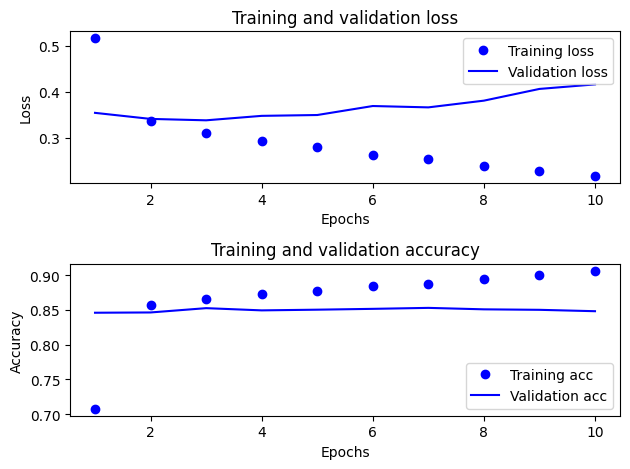

In [71]:
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
history_dict = history_conv1.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


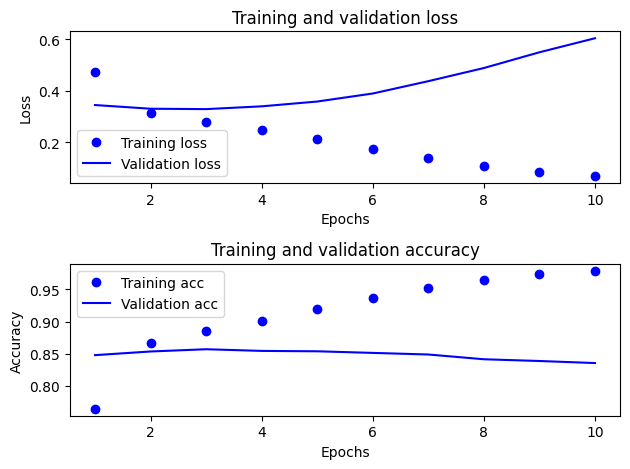

In [73]:
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [74]:
history_dict = history_gmp1.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


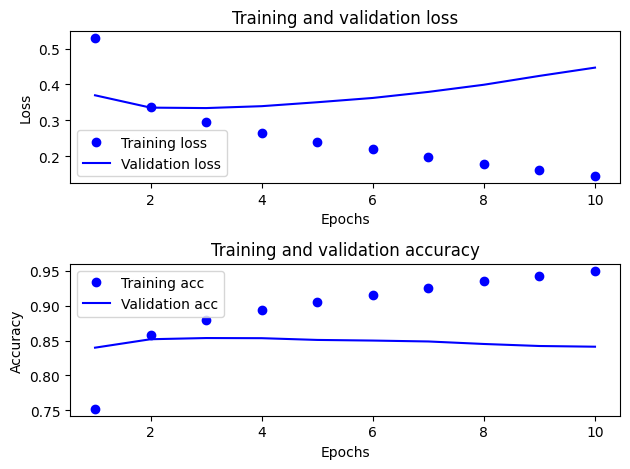

In [75]:
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 7) 학습된 Embedding 레이어 분석
----

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

  
  
```python
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv[‘끝’]
```